<a href="https://colab.research.google.com/github/DarkTouiZ/player-intelligence-system/blob/main/task4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting Up

## Install Dependencies

In [21]:
%%capture
# Install dependencies
!pip install fastai jupyter timm torchtnt

# Install utility packages
!pip install cjm_pandas_utils cjm_psl_utils cjm_pil_utils cjm_pytorch_utils cjm_torchvision_tfms

# Kaggle
!pip install kaggle

# imagehash
!pip install imagehash

In [2]:
import os
from google.colab import userdata
kaggle_json_str = userdata.get('KAGGLE_API_TOKEN')
!mkdir -p ~/.kaggle
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write(kaggle_json_str)
!chmod 600 ~/.kaggle/kaggle.json

## Import Libraries

In [3]:
# Import Python Standard Library dependencies
from copy import copy
import datetime
import json
import math
from pathlib import Path
import random
from tqdm import tqdm

# Import utility functions
from cjm_psl_utils.core import download_file, get_source_code
from cjm_pandas_utils.core import markdown_to_pandas
from cjm_pil_utils.core import resize_img, get_img_files
from cjm_pytorch_utils.core import pil_to_tensor, tensor_to_pil, denorm_img_tensor
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomTrivialAugmentWide

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# Import pandas module for data manipulation
import pandas as pd

# Set options for Pandas DataFrame display
pd.set_option('max_colwidth', None)  # Do not truncate the contents of cells in the DataFrame
pd.set_option('display.max_rows', None)  # Display all rows in the DataFrame
pd.set_option('display.max_columns', None)  # Display all columns in the DataFrame

# Import PIL for image manipulation
from PIL import Image

# Import timm library
import timm
from timm.data import resolve_model_data_config

# Import PyTorch dependencies
import torch
import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms.v2  as transforms
from torchvision.transforms.v2 import functional as TF
from torchtnt.utils import get_module_summary

# Import fastai computer vision functionality
from fastai.vision.all import *

## Download Dataset from Kaggle

In [4]:
!kaggle competitions download -c cpe342-karena

 93% 860M/922M [00:00<00:00, 1.76GB/s]
100% 922M/922M [00:00<00:00, 1.84GB/s]


In [5]:
%%capture
!unzip /content/cpe342-karena.zip

## Config

In [6]:
seed = 2025
set_seed(seed)

In [7]:
device = default_device()
dtype = torch.float32
device, dtype

(device(type='cpu'), torch.float32)

In [8]:
data_dir = '/content/public_dataset/task4'

root = Path(data_dir)

# Prepare Dataset

In [9]:
train_df = pd.read_csv(root/"train.csv")
val_df   = pd.read_csv(root/"val.csv")
test_df  = pd.read_csv(root/"test_refined.csv")

train_df.head()

id    file_name  label
0  PLY00001  su7tkav.jpg      0
1  PLY00002  shlk51f.jpg      4
2  PLY00003  sbdqvs0.jpg      0
3  PLY00004  s6oe1m9.jpg      2
4  PLY00005  skn51jb.jpg      0

In [10]:
train_df['subset'] = 'train'
val_df['subset'] = 'val'
test_df['subset'] = 'test'

df = pd.concat([train_df, val_df], ignore_index=True)
val_idx = range(len(train_df), len(df))

In [11]:
label_map = {
    0: '7-11K',
    1: 'fiveN',
    2: 'freefried',
    3: 'pube',
    4: 'roblock'
}

df['label'] = df['label'].map(label_map).astype(str)
test_df['label'] = test_df['label'].map(label_map).astype(str)

# Exploratory Data Analysis

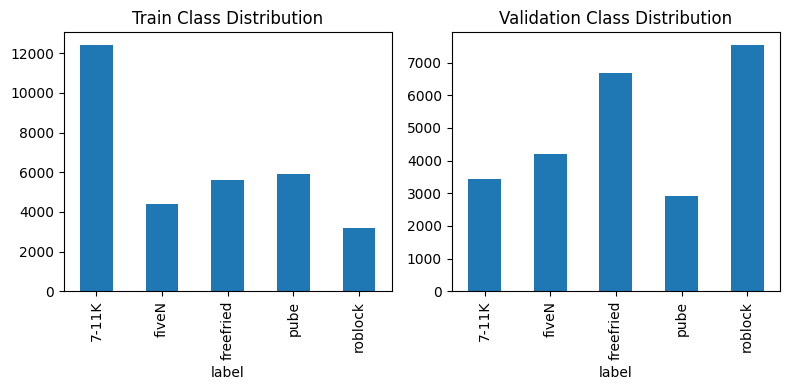

In [20]:
# See class distribution
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

consistent_labels = sorted(df['label'].unique())

df_train_plot = df[df['subset'] == 'train'].copy()
df_val_plot = df[df['subset'] == 'val'].copy()

df_train_plot['label'] = pd.Categorical(df_train_plot['label'], categories=consistent_labels, ordered=True)
df_val_plot['label'] = pd.Categorical(df_val_plot['label'], categories=consistent_labels, ordered=True)

df_train_plot['label'].value_counts(sort=False).plot.bar(ax=axes[0], title='Train Class Distribution')
df_val_plot['label'].value_counts(sort=False).plot.bar(ax=axes[1], title='Validation Class Distribution')

plt.tight_layout()
plt.show()

## Exploring Image Duplicates 🧐

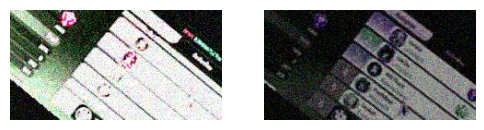

In [51]:
# From a quick inspection of the dataset, I found several highly similar image pairs.
img1 = Image.open(root/'train'/"s0b25h6.jpg")
img2 = Image.open(root/'train'/"s001sz9.jpg")

plt.figure(figsize=(6,3))
for i, img in enumerate([img1, img2], 1):
    plt.subplot(1,2,i)
    plt.imshow(img); plt.axis('off')
plt.show()

In [52]:
import imagehash
phash1 = imagehash.phash(img1)
phash2 = imagehash.phash(img2)
print(f"phash1: {phash1}")
print(f"phash2: {phash2}")

phash1: 905a23e71f0a7f45
phash2: 945a6ba717466b49


In [56]:
gs_hash = imagehash.hex_to_hash(str(phash1))
ori_hash = imagehash.hex_to_hash(str(phash2))
print('Hamming distance:', gs_hash - ori_hash)

Hamming distance: 12


In [109]:
import imagehash
from collections import defaultdict

# compute phash
print("computing phash ...")

val_path = root / 'val'
files = [f for f in os.listdir(val_path) if f.lower().endswith(('.jpg','.png','.jpeg'))]
hash_dict = {}
for f in tqdm(files):
    try:
        h = imagehash.phash(Image.open(val_path/f))
        hash_dict[f] = h
    except:
        pass

# group by hash prefix (reduce comparisons)
buckets = defaultdict(list)
for fname, h in hash_dict.items():
    prefix = str(h)[:4]
    buckets[prefix].append((fname, h))

# compare only images within same bucket
print("finding near-duplicates ...")
pairs = []
for bucket in buckets.values():
    for i in range(len(bucket)):
        for j in range(i+1, len(bucket)):
            f1, h1 = bucket[i]
            f2, h2 = bucket[j]
            if (h1 - h2) < 6:
                pairs.append((f1, f2))

print(f"Found {len(pairs)} near duplicates.")

computing phash ...


100%|██████████| 24772/24772 [00:17<00:00, 1400.87it/s]


finding near-duplicates ...
Found 302 near duplicates.


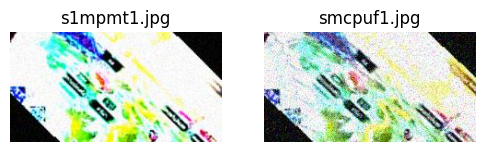

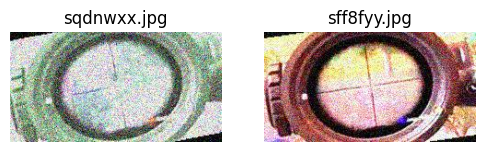

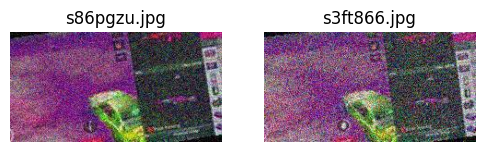

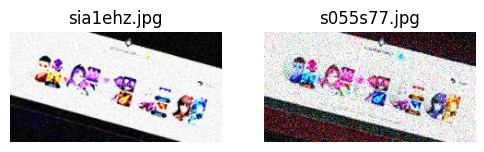

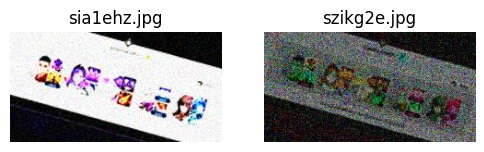

In [111]:
def show_pair(f1, f2):
    img1 = Image.open(val_path / f1)
    img2 = Image.open(val_path / f2)

    plt.figure(figsize=(6,3))
    for i, img in enumerate([img1, img2], 1):
        plt.subplot(1,2,i); plt.imshow(img); plt.title([f1,f2][i-1]); plt.axis('off')
    plt.show()

# preview first 5 pairs
for f1, f2, *_ in pairs[-5:]:
    show_pair(f1, f2)


> **Findings:** From this exploration, we discovered that the validation set contains closely duplicated images. Therefore, we decided not to merge the train and validation sets or create a new split, as it could introduce data leakage.

# Modeling

For this section, I chose the `eva02_large_patch14_448.mim_m38m_ft_in22k_in1k` model, which is one of the best-performing models on the [Timm Leaderboard](https://huggingface.co/spaces/timm/leaderboard).
To improve robustness across diverse domains, I applied various image augmentation techniques such as **ColorJitter**, **CutMix**, and **RandomErasing**.
For training strategies, I also incorporated **EarlyStopping** and **WeightDecay** to mitigate overfitting.

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
model_name = "eva02_large_patch14_448.mim_m38m_ft_in22k_in1k"
model = timm.create_model(model_name, pretrained=True)
model.reset_classifier(num_classes=5)
print(model.get_classifier())

config = resolve_model_data_config(model)

mean, std = config["mean"], config["std"]
interp = config["interpolation"]
crop_pct = config.get("crop_pct", 1.0)
size = config["input_size"][-1]

model.safetensors:   0%|          | 0.00/3.39G [00:00<?, ?B/s]

Linear(in_features=3072, out_features=5, bias=True)


In [ ]:
from fastai.vision.core import PILImage
from fasttransform import Transform

class AlbumentationsTransform(Transform):
    def __init__(self, aug):
        self.aug = aug

    def encodes(self, img: PILImage):
        import numpy as np
        arr = np.array(img)
        auged = self.aug(image=arr)['image']
        return PILImage.create(auged)

In [ ]:
def get_x(r): return root / r['subset'] / r['file_name']
def get_y(r): return r['label']

# define albumentations pipeline
albu_tfms = A.Compose([
    A.GaussianBlur(blur_limit=(3, 7), p=0.3),
    A.GaussNoise(var_limit=(5, 40), mean=0, p=0.3),
    A.ImageCompression(quality_range=(40, 80), p=0.3),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.4),
], p=0.8)

batch_tfms = [
    *aug_transforms(
        do_flip=True,
        flip_vert=False,
        max_rotate=20,
        max_lighting=0.4,
        max_zoom=1.2,
        max_warp=0.2,
        p_affine=0.8,
        p_lighting=0.8
    ),
    RandomErasing(p=0.4, max_count=3, sh=0.2),
    AlbumentationsTransform(albu_tfms),
    Normalize.from_stats(mean, std)
]

item_tfms = [Resize(size, method=interp)]

/tmp/ipython-input-3812706787.py:7: UserWarning: Argument(s) 'var_limit, mean' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(5, 40), mean=0, p=0.3),


In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=get_x,
    get_y=get_y,
    splitter=IndexSplitter(val_idx),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms
)

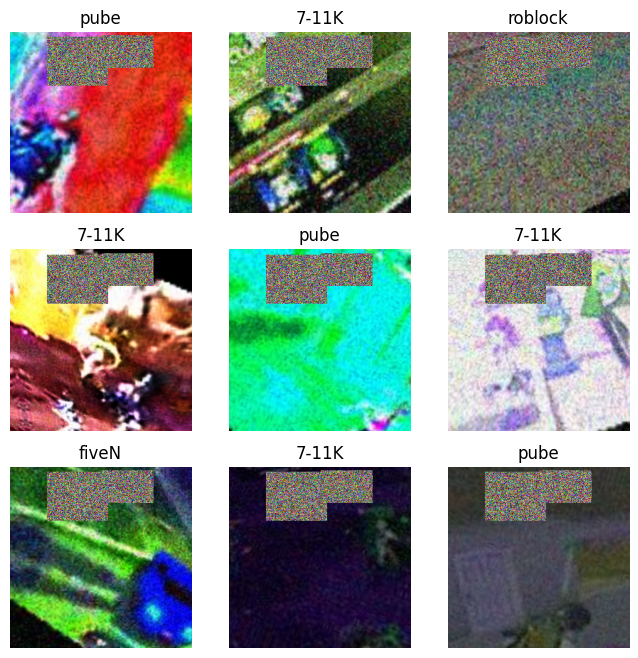

In [ ]:
dls = dblock.dataloaders(df, bs=32, num_workers=2)
dls.show_batch(max_n=9, figsize=(8, 8))

In [ ]:
from fastai.callback.mixup import CutMix

# CutMix
cutmix_cb = CutMix(alpha=1.0)

In [ ]:
learn = Learner(
    dls,
    model,
    metrics=[accuracy, F1Score(average='macro')],
    cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3),
         SaveModelCallback(monitor='f1_score', fname='best_model'),
         cutmix_cb],
).to_fp16()

In [ ]:
learn.load("/content/drive/MyDrive/eva02_L_best")

'Learning Rate: 0.00022757327678846195'

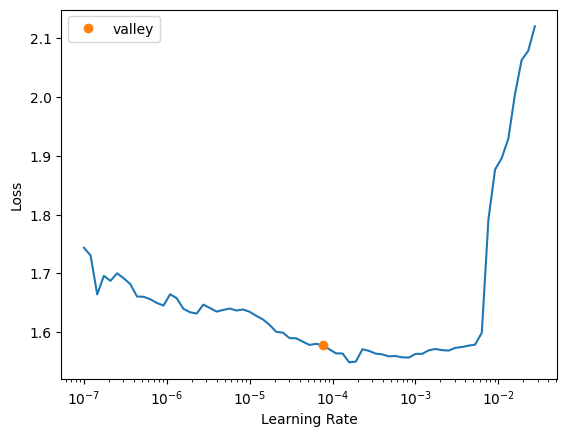

In [ ]:
suggested_lrs = learn.lr_find()
lr = suggested_lrs.valley*3
f"Learning Rate: {lr}"

> The learning rate was set to a value slightly above the valley suggested by the LR finder, as optimal learning typically occurs within the flat, stable region just beyond the minimum loss point [REF](https://medium.com/@bijil.subhash/transfer-learning-how-to-pick-the-optimal-learning-rate-c8621b89c036). This choice balances training efficiency and stability.



In [ ]:
learn.fine_tune(10, base_lr=lr, wd=0.005)

Better model found at epoch 0 with f1_score value: 0.5247658982181697.


Better model found at epoch 0 with f1_score value: 0.6821838441503505.
Better model found at epoch 1 with f1_score value: 0.7221130986862458.
Better model found at epoch 2 with f1_score value: 0.722995971908608.
Better model found at epoch 5 with f1_score value: 0.7522711797676307.
No improvement since epoch 2: early stopping


In [ ]:
learn.load('best_model')

/usr/local/lib/python3.12/dist-packages/fastai/learner.py:67: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


# Evaluation

In this section, I evaluated the model’s performance using multiple metrics and experimented with test-time augmentation (TTA) to ensure that the model's predictions remain robust when applied to unseen domains.

### Normal Prediction

In [ ]:
preds,targs = learn.get_preds(dl=dls.valid)

In [ ]:
targs

tensor([4, 3, 1,  ..., 4, 4, 2])

In [ ]:
acc = accuracy(preds, targs)
f1 = F1Score(average='macro')(preds.argmax(axis=1), targs)

In [ ]:
acc, f1

(TensorBase(0.8393), 0.8297818311039323)

### TTA Prediction (Test-time Augment)

In [ ]:
preds_tta, targs = learn.tta(dl=dls.valid)

In [ ]:
preds_tta.argmax(axis=1), targs

(tensor([4, 3, 1,  ..., 4, 0, 2]), tensor([4, 3, 1,  ..., 4, 4, 2]))

In [ ]:
acc = accuracy(preds_tta, targs)
f1 = F1Score(average='macro')(preds_tta.argmax(axis=1), targs)

In [ ]:
acc, f1

(TensorBase(0.8355), 0.8256503171108246)

## Error Visualization

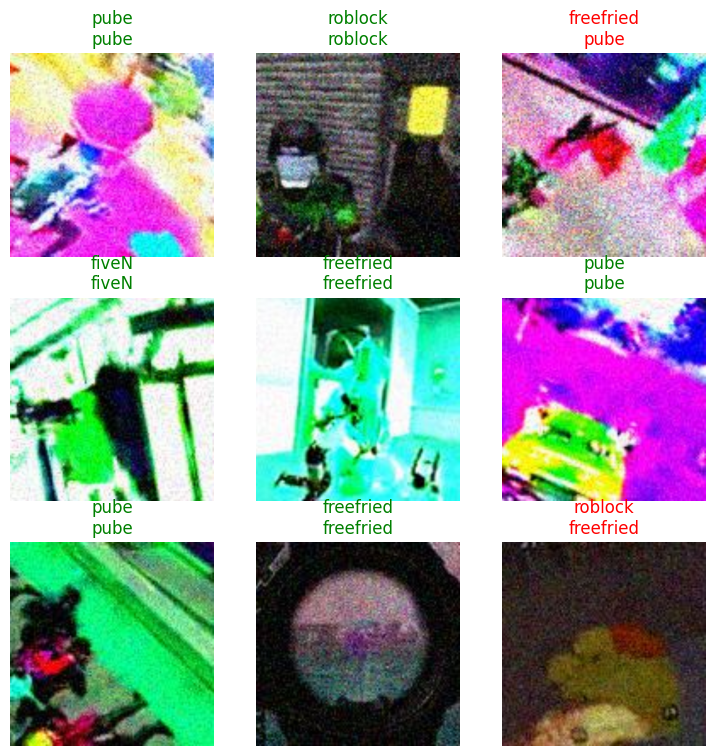

In [ ]:
learn.show_results()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.print_classification_report()

KeyboardInterrupt: 

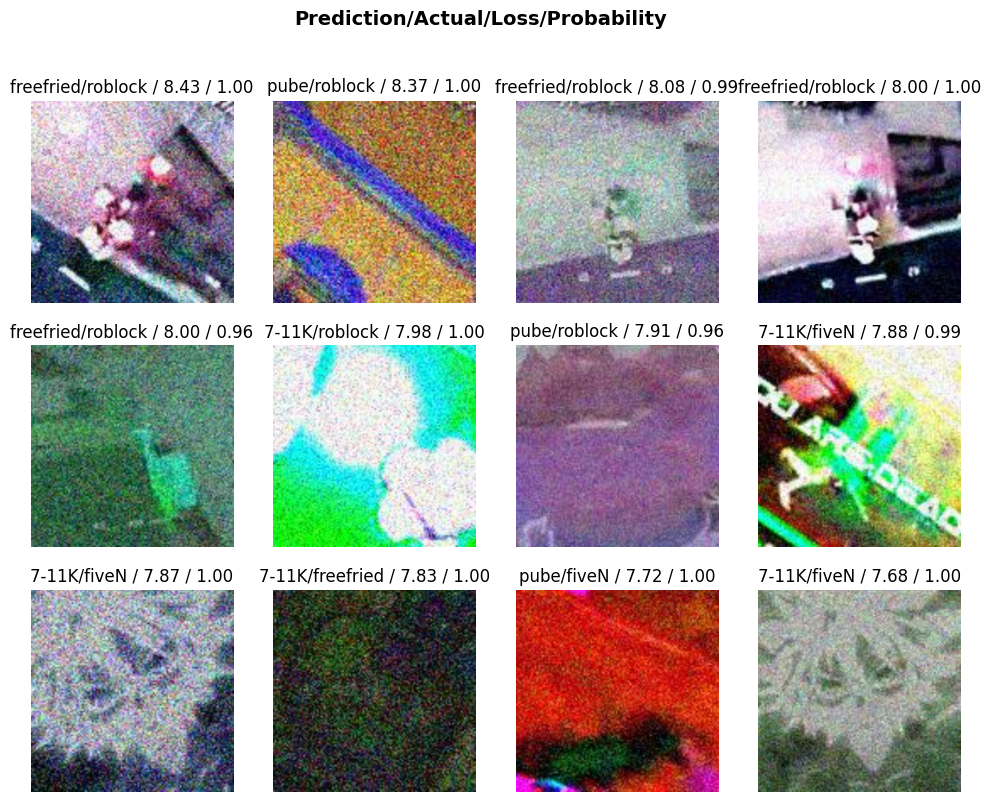

In [ ]:
interp.plot_top_losses(k=12)

In [ ]:
learn.save('/content/drive/MyDrive/eva02_L_best')

Path('/content/drive/MyDrive/eva02_L_best.pth')

# Predict and Submission

In [ ]:
test_files = [root/"test"/f for f in test_df['file_name']]
test_dl = learn.dls.test_dl(test_files)

preds,_ = learn.get_preds(dl=test_dl)

In [ ]:
# TTA
preds,_ = learn.tta(dl=test_dl)

In [ ]:
preds

tensor([[9.1785e-01, 7.1961e-02, 6.6804e-03, 2.7957e-03, 7.1729e-04],
        [3.8039e-04, 1.8145e-04, 9.9874e-01, 5.9291e-04, 1.0481e-04],
        [7.4803e-03, 4.1933e-03, 8.5166e-04, 9.8742e-01, 5.9157e-05],
        ...,
        [8.7237e-02, 6.2789e-02, 2.7659e-02, 1.8786e-01, 6.3445e-01],
        [2.0037e-01, 2.4162e-03, 8.1409e-04, 7.0052e-03, 7.8939e-01],
        [9.6912e-01, 5.5635e-03, 1.6134e-02, 3.3027e-03, 5.8820e-03]])

In [ ]:
pred_labels = preds.argmax(dim=1)

submission = pd.DataFrame({
    "image": test_df['file_name'],
    "label": pred_labels
})

submission.head()

image  label
0  sjqyfwc.jpg      0
1  s07kzz5.jpg      2
2  sr69rma.jpg      3
3  soqvor4.jpg      0
4  s2v4jw3.jpg      3

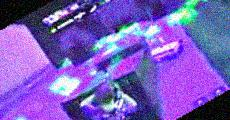

In [ ]:
idx = 2
Image.open(test_files[idx])

In [ ]:
label_map[int(pred_labels[idx])]

'pube'

In [ ]:
best_csv = pd.read_csv("/content/ThreeTreeStackEnsembleHyperparameter0.2-VVS_XGBV1-TweedieCATB_optuna_featEn-ConvNextxxl_aug-isoXsvm.csv")
best_csv.head()

id  task1  task2          task3  task4  task5
0  ANS00001      1      2     496.056891      2      1
1  ANS00002      0      1     904.887028      1      1
2  ANS00003      1      3  148248.266429      3      0
3  ANS00004      0      2      79.755910      3      1
4  ANS00005      1      0     260.016682      3      0

In [ ]:
best_csv["task4"] = pred_labels.numpy()

In [ ]:
best_csv.head()

id  task1  task2          task3  task4  task5
0  ANS00001      1      2     496.056891      0      1
1  ANS00002      0      1     904.887028      2      1
2  ANS00003      1      3  148248.266429      3      0
3  ANS00004      0      2      79.755910      0      1
4  ANS00005      1      0     260.016682      3      0

In [ ]:
best_csv.to_csv("/content/ThreeTreeStackEnsembleHyperparameter0.2-VVS_XGBV1-TweedieCATB_optuna_featEn-EVA02_L_AUG-isoXsvm.csv", index=False)